# Determinación de la edad

## Descripción del Proyecto
La red de supermercados "Pan-Sal" introduce un sistema de visión por ordenador para el procesamiento de fotos de los compradores. La fijación fotográfica en la zona de casasse ayudará a determinar la edad de los clientes para:
Analizar compras y ofrecer productos que puedan ser de interés para compradores de este grupo de edad;
Controlar la integridad de los cajeros al vender alcohol.
Construir un modelo que determinará la edad aproximada de la persona. A su disposición es un conjunto de fotos de personas por edad.

#### Pasos de progreso del proyecto
- Vamos a hacer un análisis de investigación de la matriz de fotos.
- Preparar los datos para la formación.
- Formamos la red neuronal y calculamos su calidad.

## Análisis exploratorio de datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Tenemos 7591 fotos, el conjunto de datos contiene el nombre del archivo de cada una y la edad real. Veamos la distribución por edades.

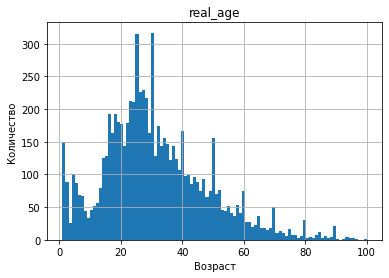

In [5]:
labels.hist(bins=100);
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Tenemos la edad de 1 a 100 años. El promedio es de 31 años. La mayoría de las fotos de personas de 20 a 41 años.

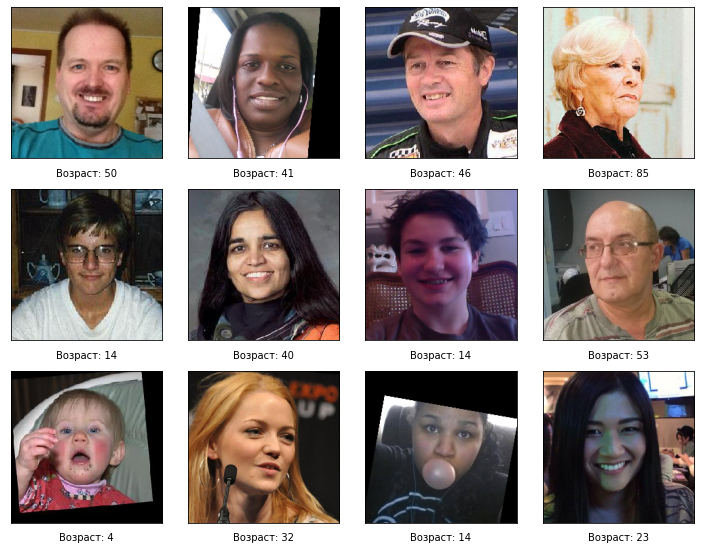

In [7]:
# Veamos ejemplos de fotos:

features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    subplt = fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.text(0.5, -0.1, f"Возраст: {target[i]}", transform=subplt.transAxes, 
             ha='center', va='center', fontsize=10)

### Conclusiones

El número de fotografías consideradas suficientes para resolver el problema de regresión depende de varios factores, como la complejidad del problema, la variabilidad de los datos, los algoritmos y los modelos utilizados para el aprendizaje. Sin embargo, 7.591 fotografías pueden ser datos suficientes para comenzar a trabajar en el problema de la regresión, especialmente si contienen ejemplos diversos y representativos.

Estos son algunos pasos que se pueden tomar para mejorar los resultados en este sentido:
- Aumento de datos para crear variaciones adicionales de las imágenes de entrada. Esto puede incluir rotaciones aleatorias, desplazamientos, cambios de tamaño, reflejos y cambios de brillo/contraste. Esos métodos contribuirían a aumentar la diversidad de datos y a mejorar la generalización del modelo.
- Seleccionar un modelo adecuado para la tarea de regresión que tenga en cuenta nuestros requisitos y características de datos.
- Ajustar los parámetros del modelo como velocidad de aprendizaje, número de capas y neuronas, función de activación y regularización para lograr un mejor rendimiento del modelo.

Las fotos recogidas contienen personas de 1 a 100 años de edad, sobre todo - 31 años de edad. La mayor parte de las fotos de las personas - de 21 a 40 años. Vemos que hay fotografías tanto en color como en blanco y negro. Parte de ellas está inclinada y contiene marcos (fondo negro). Los rostros de las personas no solo son de rostro completo, sino también de perfil, con los ojos cerrados, con diferentes expresiones.

Lo utilizamos en modelos de entrenamiento de aumento con reflexión horizontal de imagen y normalización de valores de píxeles. Estos métodos ayudarán a aumentar la diversidad de datos y a proporcionar un aprendizaje modelo más estable.

## Entrenamiento de modelos

El código en esta sección se ejecuta en un simulador de GPU separado, por lo que no está diseñado como una celda con un código, sino como un código en una celda de texto

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-05-14 20:34:13.137416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-14 20:34:13.680027: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 62s - loss: 201.5174 - mae: 10.3796 - val_loss: 716.9814 - val_mae: 21.7744
Epoch 2/10
356/356 - 61s - loss: 83.6211 - mae: 6.9444 - val_loss: 139.2186 - val_mae: 8.8687
Epoch 3/10
356/356 - 64s - loss: 58.3811 - mae: 5.8514 - val_loss: 87.5211 - val_mae: 6.9818
Epoch 4/10
356/356 - 53s - loss: 41.3148 - mae: 4.9407 - val_loss: 104.3884 - val_mae: 7.6344
Epoch 5/10
356/356 - 42s - loss: 32.8057 - mae: 4.3723 - val_loss: 74.6835 - val_mae: 6.4877
Epoch 6/10
356/356 - 42s - loss: 27.0806 - mae: 3.9961 - val_loss: 67.8471 - val_mae: 6.2243
Epoch 7/10
356/356 - 42s - loss: 21.1135 - mae: 3.4978 - val_loss: 64.1587 - val_mae: 6.2175
Epoch 8/10
356/356 - 43s - loss: 17.2530 - mae: 3.1456 - val_loss: 67.2812 - val_mae: 6.2276
Epoch 9/10
356/356 - 49s - loss: 15.1074 - mae: 2.9639 - val_loss: 64.0706 - val_mae: 6.0309
Epoch 10/10
356/356 - 64s - loss: 12.9584 - mae: 2.7305 - val_loss: 70.3083 - val_mae: 6.4020
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 70.3083 - mae: 6.4020
Test MAE: 6.4020

```

## Análisis del modelo aprendido

- Utilizamos el modelo ResNet50. La formación fue rápida. MAE logró llegar a 6,4 en 10 épocas.

- Se permite un error de 6 años excepto en casos de venta de alcohol.

El uso de GPU y redes neuronales permite el procesamiento rápido y preciso de grandes cantidades de información. En la práctica, esto se aplica en las tiendas para determinar la edad de los compradores y proporcionar ofertas personalizadas de acuerdo a sus intereses y edad. Gracias al uso de redes neuronales y GPU, estos sistemas pueden funcionar de forma rápida y eficiente, proporcionando comodidad y calidad de servicio a los compradores.